In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF statistic: %f' % result[0])
    print('p-value: %f' % result[1])

## Original Series

In [3]:
ts = pd.read_csv('original_series.csv')
ts.index = np.arange(1 , len(ts) + 1)

Text(0, 0.5, 'Views')

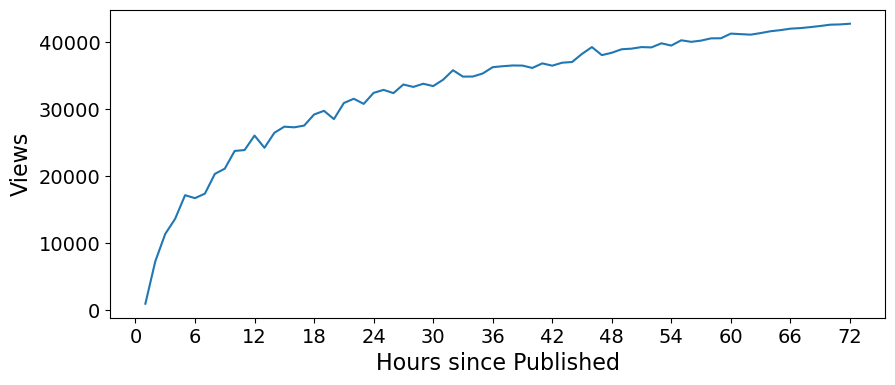

In [4]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6) , fontsize = 14)
plt.xlabel('Hours since Published' , fontsize = 16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

### To apply any TS model , we have to make the data stationary , and for that we will apply the following steps:

### 1] Normalise the data ( Z-Scaling )
### 2] Exponentiate the data ( as it appears to be logarithmic and hence it shud straighten it out sort of)
### 3] First Difference of the above series to make it stationary

### Normalising the Data

In [5]:
mu = np.mean(ts)
sigma = np.std(ts)

normalised_ts = (ts - mu) / sigma

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Text(0, 0.5, 'Normalised Views')

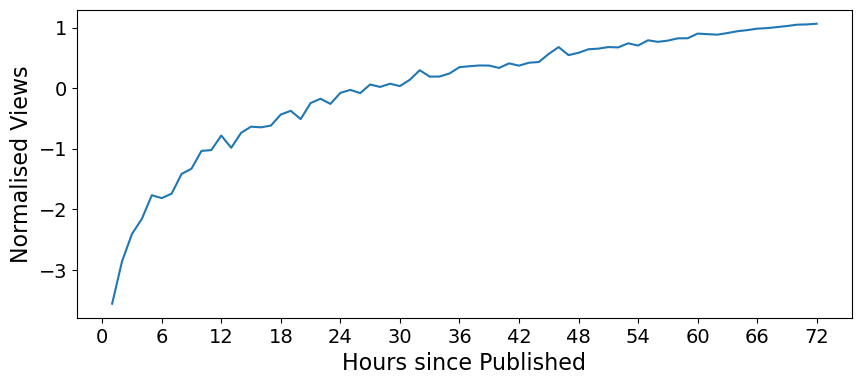

In [6]:
plt.figure(figsize=(10,4))
plt.plot(normalised_ts)

plt.xticks(np.arange(0,78,6) , fontsize = 14)
plt.xlabel('Hours since Published' , fontsize = 16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Normalised Views', fontsize=16)

### Exponentiating the Series

In [7]:
exp_ts = np.exp(normalised_ts)

Text(0, 0.5, 'Exponentiated Normalised Views')

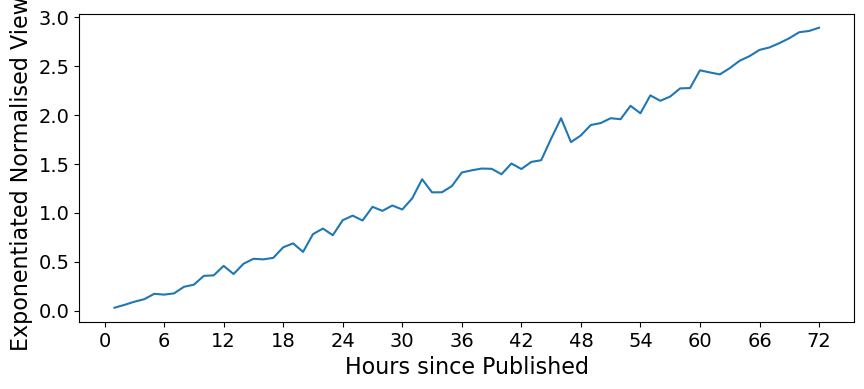

In [8]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6) , fontsize = 14)
plt.xlabel('Hours since Published' , fontsize = 16)

plt.yticks(np.arange(0,3.5,0.5), fontsize=14)
plt.ylabel('Exponentiated Normalised Views', fontsize=16)

#### Now performing a Dickey Fuller test on the above time series to check if its stationary or not , its stationary only if p-value < 0.05, the reason is that the null hypothesis is that the data is not stationary, and we can reject the null hypothesis (ie the data is stationary) only and only when p value < 0.05

In [9]:
perform_adf_test(exp_ts)

ADF statistic: 1.648979
p-value: 0.997997


#### Since its not stationary and as visible from above graph that the mean is not constant, we shud take the first difference

In [10]:
diff_ts = exp_ts.diff().dropna()

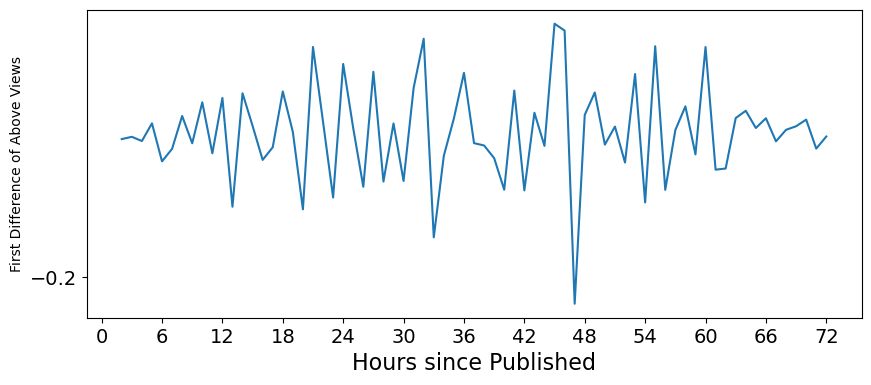

In [11]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6) , fontsize = 14)
plt.xlabel('Hours since Published' , fontsize = 16)

plt.yticks(np.arange(-0.2,0.3), fontsize=14)
plt.ylabel('First Difference of Above Views')

plt.show()

#### Again Performing Dickey Fuller test for confirmation

In [12]:
perform_adf_test(diff_ts)

ADF statistic: -4.881064
p-value: 0.000038


### Now we can apply our TS models

### Trying to fit an AR model

#### Hence plotting the PACF to get the order of the lags

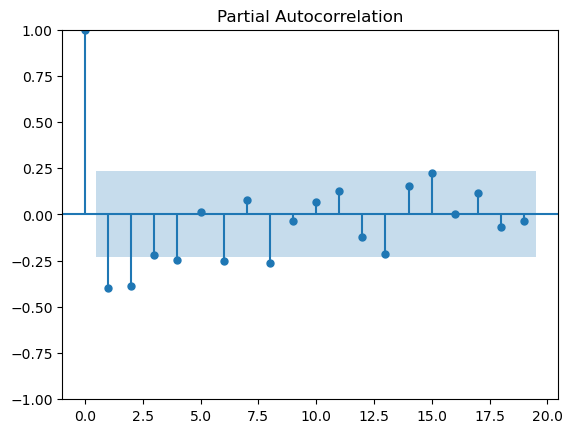

In [13]:
plot_pacf(diff_ts)
plt.show()

#### Starting with an AR4 Process as technically first 4 lags are noticably > 0

### Now using ACF for lag order of MA

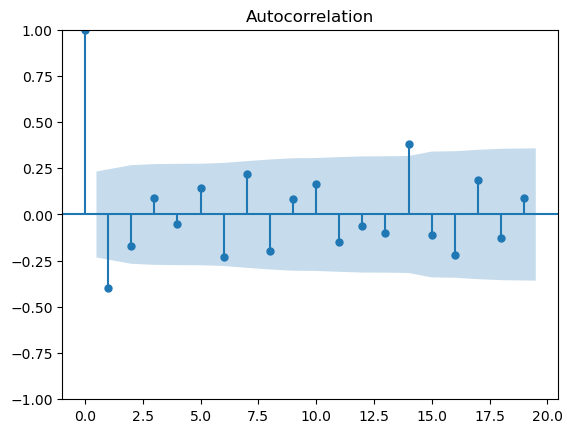

In [14]:
plot_acf(diff_ts)
plt.show()

#### MA1 model shud be sufficient

### Hence our overall model shud be ARIMA(4,0,1)

## Creating the Model

In [15]:
model = ARIMA(diff_ts , order = (4,0,1))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [16]:
model_fit = model.fit()

In [17]:
predictions = model_fit.forecast(3)

# To get confidence intervals, use get_forecast() and conf_int() methods
forecast_object = model_fit.get_forecast(3)
conf_int = forecast_object.conf_int()
lower_bound = conf_int.iloc[:, 0]  # First column is lower bound
upper_bound = conf_int.iloc[:, 1]  # Second column is upper bound

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


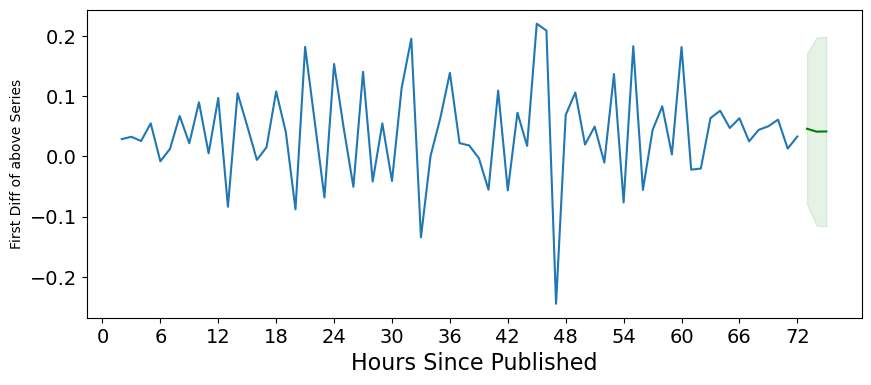

In [18]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff of above Series')

plt.plot(np.arange(len(ts)+1, len(ts)+4), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), lower_bound, upper_bound, color='g', alpha=0.1)

#### But ofcourse , this predicts the first difference of the exponentiated normalised views , while we wanted to predict just the views , hence now we reverse the above applied transformations on the above predictions

### So now to reverse it we have to do the following steps

#### 1] Firstly add the prev datapoint to the current data point to get just the exponentiated normalised views
#### 2] Then we have to take the ln of that to get just the normalised views
#### 3] Then we have to multiply it with standard deviation and add the mean to finally get the views

In [19]:
def undo_transformations(predictions, series, mu, sigma):
    # Convert predictions to numpy array if it's not already
    predictions = np.array(predictions).flatten()
    
    # Now access the first element
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [20]:
orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

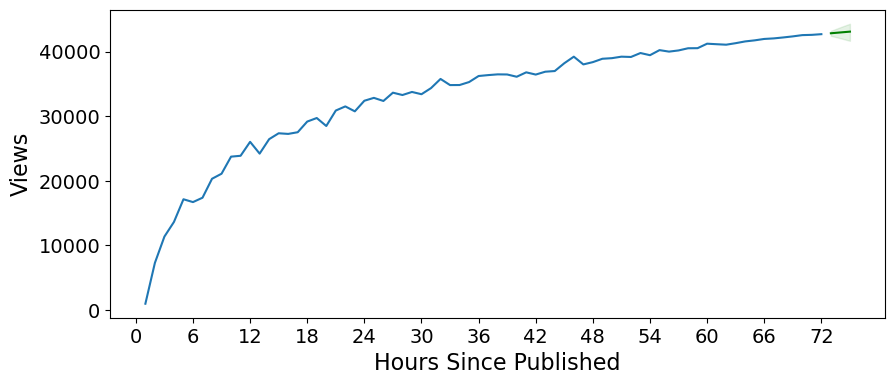

In [21]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6) , fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1 , len(ts)+4) , orig_preds , color = 'g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)

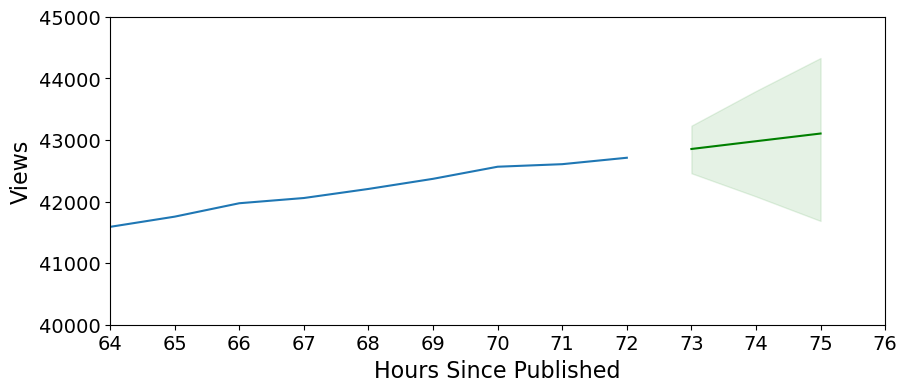

In [22]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)
plt.xlim(64,76)
plt.ylim(40000, 45000)

plt.show()